## Fig S11: Changing repressor copy number for a double-repression promoter under XOR logic.

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/figS11/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

The energy matrices for the two repressors are randomly generated using the `generate_emap` function

In [5]:
rep1_site = promoter[(115):(115+10)]
rep2_site = promoter[(115+20):(115+30)]

r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

### 1.1 Average mutual information as a function of repressor copy number for a double repression promoter with XOR regulatory logic

In [6]:
def doublerep_pbound_xor(p_seq, r1_seq, r2_seq, n_NS, n_p, n_r1, n_r2,
                        p_emat, r1_emat, r2_emat, 
                        ep_wt, er1_wt, er2_wt, e_int_r1r2):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r1 = tregs.simulate.get_weight(r1_seq, r1_emat, e_wt=er1_wt)
    w_r2 = tregs.simulate.get_weight(r2_seq, r2_emat, e_wt=er2_wt)

    z = np.zeros(8)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = n_r1 / n_NS * w_r1
    z[3] = n_r2 / n_NS * w_r2
    z[4] = (n_p / n_NS * w_p) * (n_r1 / n_NS * w_r1)
    z[5] = (n_p / n_NS * w_p) * (n_r2 / n_NS * w_r2)
    z[6] = (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int_r1r2)
    z[7] = (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * (n_p / n_NS * w_p) * np.exp(-e_int_r1r2) # ON
    pbound = (z[1] + z[7]) / np.sum(z)

    return pbound

For each repressor copy number, we simulate 200 synthetic datasets in order to observe the average effects. To save computational time, we first generate 200 mutant libraries beforehand using the function `mutations_rand`.

In [7]:
num_mutants = 200

mutant_bank = []
for i in range(num_mutants):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We calculate the average mutual information at the two repressor binding sites for a double repression promoter under XOR logic while changing the copy number of the first repressor 

In [8]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = 5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

signal_r1 = np.zeros((len(l_n_r1), num_mutants))
signal_r2 = np.zeros((len(l_n_r1), num_mutants))

for i, n_r1 in enumerate(l_n_r1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, doublerep_pbound_xor,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        signal_r1[i, j] = np.mean(footprint[(115):(115+10)])
        signal_r2[i, j] = np.mean(footprint[(115+20):(115+30)])

We plot the average mutual information at the repressor binding sites against the copy number of the first repressor.

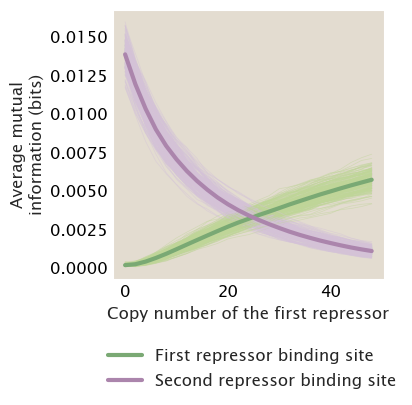

In [9]:
fig, ax = plt.subplots(figsize=(3.5,3.5))

for i in range(num_mutants):
    ax.plot(l_n_r1, signal_r1[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax.plot(l_n_r1, signal_r2[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax.plot(l_n_r1, np.mean(signal_r1, axis=1), label='First repressor binding site', color='#7AA974', linewidth=3)
ax.plot(l_n_r1, np.mean(signal_r2, axis=1), label='Second repressor binding site', color='#AB85AC', linewidth=3)

ax.set_xlabel('Copy number of the first repressor', fontsize=12)
ax.set_ylabel('Average mutual\ninformation (bits)', fontsize=12)

ax.legend(bbox_to_anchor=(1.1, -0.2), frameon=False, fontsize=12)

#plt.tight_layout()
plt.savefig(out_fdir + 'double_repression_xor.pdf', bbox_inches='tight')

We also plot the ratio of the average mutual information beteween the two repressor binding sites against the copy number of the first repressor.

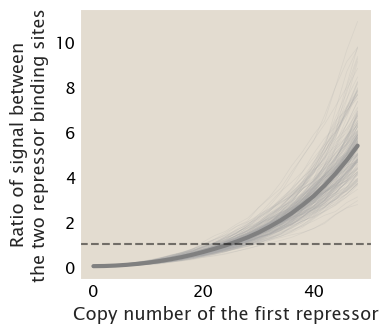

In [10]:
fig, ax = plt.subplots(figsize=(3.75,3.5))

for i in range(num_mutants):
    ax.plot(l_n_r1, np.asarray(signal_r1)[:, i] / np.asarray(signal_r2)[:, i],
            color='darkgrey', alpha=0.2, linewidth=0.5)
ax.plot(l_n_r1, np.mean(signal_r1, axis=1) / np.mean(signal_r2, axis=1),
        color='grey', linewidth=3)
ax.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('Ratio of signal between\nthe two repressor binding sites', fontsize=13)
ax.set_xlabel('Copy number of the first repressor', fontsize=13)

plt.autoscale()
plt.savefig(out_fdir + 'double_repression_xor_ratio.pdf', bbox_inches='tight')

### 1.2 Representative information footprints of a double repression promoter under XOR logic

In order to plot a few representative information footprints, we first define the following standard parameters.

In [11]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = 5
n_p, n_r2 = 5000, 25

Plotting an information footprint where the copy number of the first repressor is 0.

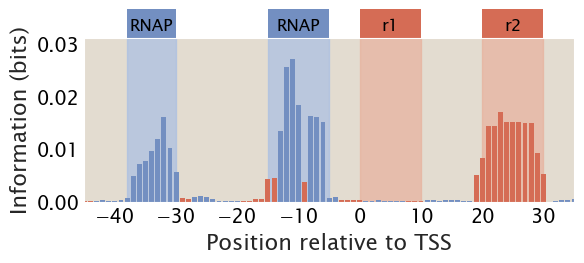

In [12]:
n_r1 = 0

df = tregs.simulate.sim(promoter, doublerep_pbound_xor, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'figR4_fp1.pdf')

Plotting an information footprint where the copy number of the first repressor is 25.

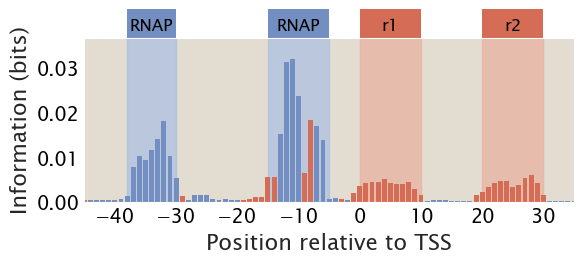

In [13]:
n_r1 = 25

df = tregs.simulate.sim(promoter, doublerep_pbound_xor, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'figR4_fp2.pdf')

Plotting an information footprint where the copy number of the first repressor is 50.

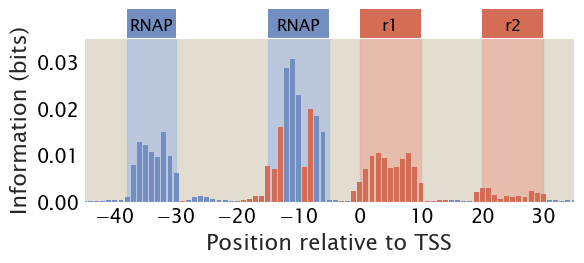

In [14]:
n_r1 = 50

df = tregs.simulate.sim(promoter, doublerep_pbound_xor, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'figR4_fp3.pdf')